In [1]:
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext    

In [4]:
csv_path = '/Users/panchescosenior/sparkdata/en.openfoodfacts.org.products.csv'

df = spark.read.option("delimiter", "\t") \
    .csv(csv_path, header=True, inferSchema=True)

In [5]:
print(f'rows: {df.count()}, cols: {len(df.columns)}')

rows: 3803302, cols: 209


### Выделяю самые полезные признаки

In [6]:
features = [
    'energy-kcal_100g', 
    'fat_100g', 
    'saturated-fat_100g', 
    'carbohydrates_100g', 
    'sugars_100g', 
    'proteins_100g', 
    'fiber_100g', 
    'salt_100g'
]

df = df.select(*features)
df.show(5)

+----------------+--------+------------------+------------------+-----------+-------------+----------+---------+
|energy-kcal_100g|fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|fiber_100g|salt_100g|
+----------------+--------+------------------+------------------+-----------+-------------+----------+---------+
|            NULL|    NULL|              NULL|              NULL|       NULL|         NULL|      NULL|     NULL|
|           332.0|    25.0|              17.3|               3.0|        1.0|         23.0|      NULL|      1.2|
|            NULL|    44.0|              28.0|              30.0|       27.0|          7.1|      NULL|    0.025|
|            NULL|    NULL|              NULL|              NULL|       NULL|         NULL|      NULL|     NULL|
|            NULL|    NULL|              NULL|              NULL|       NULL|         NULL|      NULL|     NULL|
+----------------+--------+------------------+------------------+-----------+-------------+-----

### Оставляю только строки без NULL

In [7]:
df = df.na.drop()
df.show(5)

+----------------+--------+------------------+------------------+-----------+-------------+----------+---------+
|energy-kcal_100g|fat_100g|saturated-fat_100g|carbohydrates_100g|sugars_100g|proteins_100g|fiber_100g|salt_100g|
+----------------+--------+------------------+------------------+-----------+-------------+----------+---------+
|           141.0|     2.7|               0.6|               0.9|        6.2|         30.0|       2.2|      0.4|
|           100.0|     0.0|               0.0|              26.0|       15.0|          1.0|       3.0|      0.0|
|           376.0|     1.6|               0.2|               6.7|        1.3|         82.0|       2.9|      1.7|
|           230.0|    11.0|               2.0|              25.0|       0.98|         22.0|       9.0|     0.95|
|             1.0|     1.0|               1.0|               1.0|        1.0|          1.0|       1.0|      1.0|
+----------------+--------+------------------+------------------+-----------+-------------+-----

In [8]:
LIMIT = 300000
df = df.limit(LIMIT)

In [10]:
print(f'rows: {df.count()}, cols: {len(df.columns)}')

rows: 300000, cols: 8


### Кластеризация

In [11]:
from pyspark.sql.functions import col, lit
from functools import reduce

columns_to_check = [c for c in features if c != 'energy-kcal_100g']
threshold = 100
max_kcal_per_100g = 900

filter_condition = reduce(
    lambda acc, c: acc & (col(c) < threshold),
    columns_to_check,
    lit(True)
)

energy_condition = col("energy-kcal_100g") < max_kcal_per_100g

positive_condition = reduce(
    lambda acc, c: acc & (col(c) > 0),
    columns_to_check + ["energy-kcal_100g"],
    lit(True)
)

df = df.filter(
    filter_condition &
    energy_condition &
    positive_condition
)


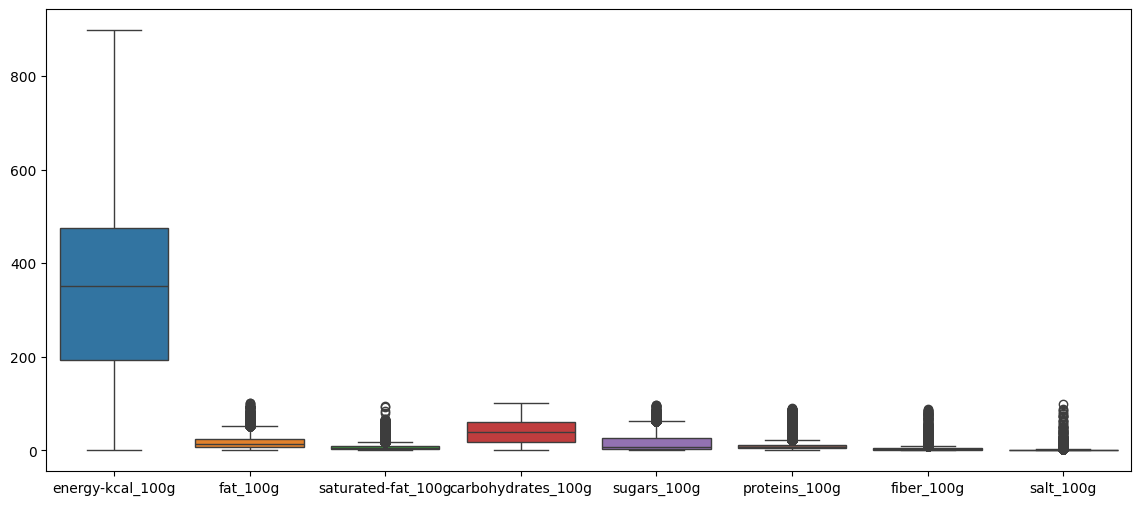

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns  

plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df.toPandas())
plt.show()

In [13]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

assembler = VectorAssembler(
    inputCols=features,
    outputCol="features_raw"
)

scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features",
    withMean=True,
    withStd=True
)

CLUSTER_COUNT = 5
seed = 42

kmeans = KMeans(k=CLUSTER_COUNT, seed=seed, featuresCol="features")

pipeline = Pipeline(stages=[assembler, scaler, kmeans])

model = pipeline.fit(df)
predictions = model.transform(df)

kmeans_model = model.stages[-1]

centers = kmeans_model.clusterCenters()
print("Cluster Centers (scaled):")
for i, c in enumerate(centers):
    print(f"Cluster {i}:", c)


25/04/23 21:52:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Cluster Centers (scaled):
Cluster 0: [ 1.36052503  2.1108255   0.48297574 -0.54774162 -0.40336896  1.29015624
  0.9241092   0.12377597]
Cluster 1: [ 0.89377889  0.6753525   1.48389083  0.89368358  1.62233685 -0.35822342
 -0.01731781 -0.31044217]
Cluster 2: [-0.97395791 -0.66676657 -0.51116546 -0.8558125  -0.61778491 -0.2251431
 -0.46162665 -0.10147097]
Cluster 3: [ 0.48780763 -0.02160034 -0.24204705  0.9313297   0.11796585 -0.1479884
  0.14208852  0.27347042]
Cluster 4: [ 0.22485821 -0.34538307 -0.19454464 -0.16672412 -0.31881925  3.42290249
  3.12313502  0.25241932]


In [14]:
kmeans_model.summary.clusterSizes

[8880, 16971, 43102, 28968, 2516]

### Метрика

In [15]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score = {silhouette:.4f}")

Silhouette Score = 0.4789


In [16]:
model_path = "/Users/panchescosenior/sparkdata/kmeans_model"
kmeans_model.save(model_path)